In [ ]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns

import string
import re
import py_vncorenlp
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import os
import matplotlib.pyplot as plt
import pickle

import logging
import pyLDAvis.gensim
from numpy import array
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
# import ldamallet
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
import os

import math


C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
c:\Program Files\Python39\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


# 1. Import users' comments data that are crawled previously

In [ ]:
test_data = pd.read_csv(r'D:\ITfiles\PythonFiles\News-Recommendation-System\Use-vnexpress-data\data.csv')
#test_data=test_data[['comment_id','article_id','content','full_name','userid','title','url']]
test_data =  test_data.iloc[0:100000,:]

In [ ]:
# Combine comments with one user
def combineComments(userid,data):
    comments = test_data.loc[test_data['userid']==userid,'content'].to_list()

    if len(comments)>= 5:
       comment_id	= test_data.loc[test_data['userid']==userid,'comment_id'].to_list()
       article_id	= test_data.loc[test_data['userid']==userid,'article_id'].to_list()
       title	= test_data.loc[test_data['userid']==userid,'title'].to_list()
       url = test_data.loc[test_data['userid']==userid,'url'].to_list()
       append	= [userid,comments,comment_id,article_id,title,url]
       data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']), 
              ignore_index=True)
       return(data)
       
    else:
       return(data)

# 2. Analyze Users' Comments

In [ ]:
# Cobining comments with one user and only get 6 features from dataset
userid_list = list(test_data['userid'].unique())
data = pd.DataFrame(columns = ["userid","comments","comments_id","article_id","title",'url'])

for i in userid_list:
    try:
        temp = int(i)
        data = combineComments(i,data)
    except:
        print('x')
        continue

C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:1

x


C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:1

In [ ]:
data.head()

,userid,comments,comments_id,article_id,title,url
0,1002611535,"[Ủa, iOS có tính năng khóa App từ lâu rồi mà. ...","[47968853, 47800135, 47703811, 47645657, 47584...","[4529373, 4527283, 4524455, 4522989, 4521000, ...",[Ý tưởng iOS 17 có khóa ứng dụng - VnExpress S...,[https://vnexpress.net/y-tuong-ios-17-co-khoa-...
1,1002611542,[Lâu nay phạt nguội xe máy vẫn là vấn đề nan g...,"[48165879, 48157811, 48157769, 48132386, 48088...","[4537874, 4537422, 4537406, 4535990, 4535329, ...","[Môtô CSGT tông liên hoàn, ba người bị thương ...",[https://vnexpress.net/moto-csgt-tong-lien-hoa...
2,1002611620,[Messi 0d nhưng lại được định giá gần gấp 3 lầ...,"[48163846, 48163447, 48162509, 48159323, 48156...","[4537829, 4537929, 4537576, 4537847, 4537527, ...",[10 đội tuyển đắt giá nhất tại World Cup 2022 ...,[https://vnexpress.net/10-doi-tuyen-dat-gia-nh...
3,1002611661,[Hy vọng 30 năm nữa hoàn thành để tôi có thể đ...,"[47983237, 38548809, 37953883, 37023659, 36523...","[4528558, 4226031, 4201350, 4167048, 4144167, ...",[Nghiên cứu đường sắt tốc độ cao 250 km/h - Vn...,[https://vnexpress.net/nghien-cuu-duong-sat-to...
4,1002611711,[Năm rồi vì 20 giây<br/>Mà cả đội bóng vạ lây ...,"[46444497, 46311714, 43222717, 42102514, 42097...","[4492456, 4488831, 4396253, 4356490, 4356752, ...",[Man Utd có thể nhờ Ferguson thuyết phục Ronal...,[https://vnexpress.net/man-utd-co-the-nho-ferg...


In [ ]:
# init segmenter, stopwords list and exclude punctuation
segmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='D:/ITfiles/PythonFiles/News-Recommendation-System')
stop = set(line.strip() for line in open('stop_words.txt', encoding='utf-8'))
stop = [w.replace(' ','_') for w in stop]
exclude = set(string.punctuation) 

In [ ]:
stop

['thỏm',
 'khó_khăn',
 'sau_đây',
 'chứ_không',
 'ở',
 'sẽ_biết',
 'thêm_vào',
 'chắc_dạ',
 'bỗng_đâu',
 'chúng_ta',
 'cha_chả',
 'ngay',
 'của_tin',
 'nước_bài',
 'bởi_nhưng',
 'như_nhau',
 'sang',
 'đều',
 'ngồi_sau',
 'bằng_như',
 'trừ_phi',
 'à_này',
 'phải_cách',
 'đã_không',
 'ít',
 'con',
 'lại_còn',
 'và',
 'để_lại',
 'tất_tần_tật',
 'ứ_ừ',
 'quá_tuổi',
 'thường_hay',
 'năm',
 'làm_tin',
 'ờ',
 'phần',
 'số_là',
 'quay',
 'đã_là',
 'không_dùng',
 'chưa_cần',
 'bản_thân',
 'phần_việc',
 'bỏ_ra',
 'gần_bên',
 'chúng_tôi',
 'còn_thời_gian',
 'sang_tay',
 'sau',
 'ngay_cả',
 'tự_tạo',
 'chọn_ra',
 'đưa',
 'khó_nói',
 'xiết_bao',
 'không_điều_kiện',
 'thà_rằng',
 'tránh_khỏi',
 'nhỉ',
 'bước',
 'tránh',
 'vâng',
 'lúc_đến',
 'lấy_xuống',
 'thấp_cơ',
 'rồi_thì',
 'cần_số',
 'tù_tì',
 'không_chỉ',
 'chợt_nhìn',
 'trong_lúc',
 'ngoài_này',
 'thốt',
 'ông',
 'bay_biến',
 'thế_à',
 'thậm_chí',
 'thấp',
 'nói_riêng',
 'nói_đến',
 'anh_ấy',
 'không_phải',
 'ầu_ơ',
 'ổng',
 'qua_lần',
 'dữ'

In [ ]:
# function to preprocessing comments 
def processComments(comments):
    #cleaning of comments
    cleanedcomments = []
    for comment in comments:
        if (type(comment)!=str):
            continue

        clean = re.compile('<.*?>')
        comment = re.sub(clean, ' ', comment) # remove html tags

        cm = re.sub('http\S+', '', comment) #remove links
        
        cm = "".join([char for char in cm if char not in string.punctuation]) #remove punctuations
        
        cm = cm.lower() #converting to lowercase letters
        
        cm = ' '.join([word for word in cm.split() if len(word)>2])
        
        cleanedcomments.append(cm)

    cleanedcomments = ' '.join(cleanedcomments) #joining all comments
    Processedcomments = segmenter.word_segment(cleanedcomments)[0] # tokenize all comments
    Processedcomments = ' '.join([word for word in Processedcomments.split() if word not in (stop)]) #removing stop words
    Processedcomments

    return Processedcomments
    
# process all tweet from all user (ptweets). then, appending into dataframe (only one dataframe)

<>:12: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \S
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\111851780.py:12: DeprecationWarning: invalid escape sequence \S
  cm = re.sub('http\S+', '', comment) #remove links


In [ ]:
data["pcomment"] = data['comments'].apply(lambda x : processComments(x))

In [ ]:
data

,userid,comments,comments_id,article_id,title,url,pcomment
0,1002611535,"[Ủa, iOS có tính năng khóa App từ lâu rồi mà. ...","[47968853, 47800135, 47703811, 47645657, 47584...","[4529373, 4527283, 4524455, 4522989, 4521000, ...",[Ý tưởng iOS 17 có khóa ứng dụng - VnExpress S...,[https://vnexpress.net/y-tuong-ios-17-co-khoa-...,ios tính_năng khoá app mục screen time nguyên_...
1,1002611542,[Lâu nay phạt nguội xe máy vẫn là vấn đề nan g...,"[48165879, 48157811, 48157769, 48132386, 48088...","[4537874, 4537422, 4537406, 4535990, 4535329, ...","[Môtô CSGT tông liên hoàn, ba người bị thương ...",[https://vnexpress.net/moto-csgt-tong-lien-hoa...,phạt nguội máy vấn nan_giải phương xác_định ch...
2,1002611620,[Messi 0d nhưng lại được định giá gần gấp 3 lầ...,"[48163846, 48163447, 48162509, 48159323, 48156...","[4537829, 4537929, 4537576, 4537847, 4537527, ...",[10 đội tuyển đắt giá nhất tại World Cup 2022 ...,[https://vnexpress.net/10-doi-tuyen-dat-gia-nh...,messi định_giá gấp thiên phản_bội ghi haha lik...
3,1002611661,[Hy vọng 30 năm nữa hoàn thành để tôi có thể đ...,"[47983237, 38548809, 37953883, 37023659, 36523...","[4528558, 4226031, 4201350, 4167048, 4144167, ...",[Nghiên cứu đường sắt tốc độ cao 250 km/h - Vn...,[https://vnexpress.net/nghien-cuu-duong-sat-to...,vọng hoàn_thành thể chuyến chết tội mấy tung_t...
4,1002611711,[Năm rồi vì 20 giây<br/>Mà cả đội bóng vạ lây ...,"[46444497, 46311714, 43222717, 42102514, 42097...","[4492456, 4488831, 4396253, 4356490, 4356752, ...",[Man Utd có thể nhờ Ferguson thuyết phục Ronal...,[https://vnexpress.net/man-utd-co-the-nho-ferg...,giây đội bóng lây chàng đôn_đáo chạy_làng rải ...
...,...,...,...,...,...,...,...
1167,1003195439,"[Tôi xài 8 plus thấy rất ổn, Lối ta đi giữa ha...","[46044055, 29691965, 10433034, 27570363, 29377...","[4481312, 3897180, 3145171, 3815894, 3889648, ...",[Đợt giảm giá iPhone lớn nhất trong năm của Ap...,"[https://vnexpress.net/bai-viet-4481312.html, ...",xài plus lối hai sườn núi ðôi làng gọi núi ðôi...
1168,1003195859,[Wesley tài năng nhưng phong thái có hướng ngạ...,"[41386472, 41339327, 39775020, 39416598, 36783...","[4338061, 4337045, 4274638, 4261133, 4157861, ...",[Wesley So: 'Quang Liêm chơi gần được như Vua ...,[https://vnexpress.net/wesley-so-quang-liem-ch...,wesley tài_năng phong_thái hướng ngạo_mạn học ...
1169,1003196529,"[chắc chắn không đủ rồi bạn ạ, có cái nào sạc ...","[47914824, 47641137, 46962534, 44949146, 40693...","[4530246, 4522291, 4505119, 4450832, 4303233, ...",[Du học nghề ở Mỹ cần bao nhiêu tiền? - VnExpr...,[https://vnexpress.net/du-hoc-nghe-o-my-can-ba...,sạc 30s kho khí nắm thiệt hoá liệu hành_chính ...
1170,1003196765,[Phải nói là CR7 đã nói ra mặt tối tại MU khôn...,"[48098544, 47954741, 40042300, 38589111, 34952...","[4536003, 4531933, 4282989, 4227893, 4084948, ...",[Man Utd thông báo về cuộc phỏng vấn của Ronal...,[https://vnexpress.net/man-utd-thong-bao-ve-cu...,cr7 mặt tối cầu_thủ dám siralex dần hình_bóng ...


# 3. Cluster users according to their interests

## Bonus use PhoBert

In [ ]:
import transformers
dir(transformers)

C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Program Files\Python39\lib\site-packages\tensorflow\python\framework\dtypes.py:29: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from tensorflow.python.lib.core import _pywrap_bfloat16
c:\Program Files\Python39\lib\site-packages\tensorflow\python\framework\dtypes.py:511: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
c:\Program Files\Python39\lib\site-packages\tensorflow\python\framework\dtypes.py:553: DeprecationWarning: `

['ALBERT_PRETRAINED_CONFIG_ARCHIVE_MAP',
 'ALBERT_PRETRAINED_MODEL_ARCHIVE_LIST',
 'ALL_PRETRAINED_CONFIG_ARCHIVE_MAP',
 'ASTConfig',
 'ASTFeatureExtractor',
 'ASTForAudioClassification',
 'ASTModel',
 'ASTPreTrainedModel',
 'AUDIO_SPECTROGRAM_TRANSFORMER_PRETRAINED_CONFIG_ARCHIVE_MAP',
 'AUDIO_SPECTROGRAM_TRANSFORMER_PRETRAINED_MODEL_ARCHIVE_LIST',
 'Adafactor',
 'AdamW',
 'AdamWeightDecay',
 'AdaptiveEmbedding',
 'AddedToken',
 'AlbertConfig',
 'AlbertForMaskedLM',
 'AlbertForMultipleChoice',
 'AlbertForPreTraining',
 'AlbertForQuestionAnswering',
 'AlbertForSequenceClassification',
 'AlbertForTokenClassification',
 'AlbertModel',
 'AlbertPreTrainedModel',
 'AlbertTokenizer',
 'AlbertTokenizerFast',
 'AudioClassificationPipeline',
 'AutoBackbone',
 'AutoConfig',
 'AutoFeatureExtractor',
 'AutoImageProcessor',
 'AutoModel',
 'AutoModelForAudioClassification',
 'AutoModelForAudioFrameClassification',
 'AutoModelForAudioXVector',
 'AutoModelForCTC',
 'AutoModelForCausalLM',
 'AutoModelF

In [ ]:
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Downloading: 100%|██████████| 543M/543M [00:56<00:00, 9.53MB/s] 
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: 100%|██████████| 895k/895k [00:01<00:00, 490kB/s]  
Downloading: 100%|██████████| 1.14M/1.14M [00:08<00:00, 136kB/s] 
Special tokens have been added in the vocabulary, make sure the associa

## Use tfidf_matrix

In [ ]:
# create tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1,
                                 use_idf=True)

# fit tfidf from pcomments
tfidf_matrix = tfidf_vectorizer.fit_transform(data.pcomment)

In [ ]:
tfidf_matrix.toarray()

array([[0.01256793, 0.        , 0.        , ..., 0.02459798, 0.        ,
        0.01970794],
       [0.03221025, 0.        , 0.        , ..., 0.010507  , 0.        ,
        0.        ],
       [0.        , 0.03683166, 0.        , ..., 0.0217432 , 0.        ,
        0.        ],
       ...,
       [0.03390487, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01409933, 0.        ,
        0.        ]])

In [ ]:
tfidf_matrix.shape
# (users x words)

(1172, 1136)

In [ ]:
# show user matrix word from tfidf
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index = data.userid)

C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,100,1000,200,2022,500,android,anh_chị,anti,app,apple,...,đức,đứng,đứt,đừng,ước,ảnh,ảnh_hưởng,ủng,ứng,ứng_dụng
userid,,,,,,,,,,,,,,,,,,,,,
1002611535,0.012568,0.000000,0.0,0.0,0.000000,0.000000,0.020740,0.000000,0.104884,0.000000,...,0.000000,0.011767,0.000000,0.016762,0.000000,0.014138,0.025554,0.024598,0.000000,0.019708
1002611542,0.032210,0.000000,0.0,0.0,0.000000,0.282135,0.000000,0.016442,0.000000,0.473166,...,0.000000,0.000000,0.017920,0.021479,0.000000,0.012078,0.021831,0.010507,0.000000,0.000000
1002611620,0.000000,0.036832,0.0,0.0,0.000000,0.077847,0.036666,0.000000,0.037084,0.000000,...,0.000000,0.104014,0.000000,0.029633,0.000000,0.149965,0.000000,0.021743,0.000000,0.000000
1002611661,0.084935,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.070881,0.000000,0.058713,0.000000,0.000000,0.000000,0.000000,0.000000
1002611711,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.016441,0.000000,0.000000,...,0.080878,0.010052,0.000000,0.021479,0.014844,0.000000,0.032745,0.010507,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003195439,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.081666,0.000000,0.058166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1003195859,0.036343,0.030123,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.017014,0.000000,0.036353,0.000000,0.000000,0.000000,0.000000,0.031753,0.000000
1003196529,0.033905,0.000000,0.0,0.0,0.057938,0.000000,0.000000,0.207682,0.000000,0.051523,...,0.000000,0.000000,0.000000,0.045219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# save model tf-idf parameters
location = 'model/'
if not os.path.exists(location):
    os.makedirs(location)

pickle.dump(tfidf_vectorizer, open("%smodel_tfidf.pickle.dat"%location, "wb")) # Save object

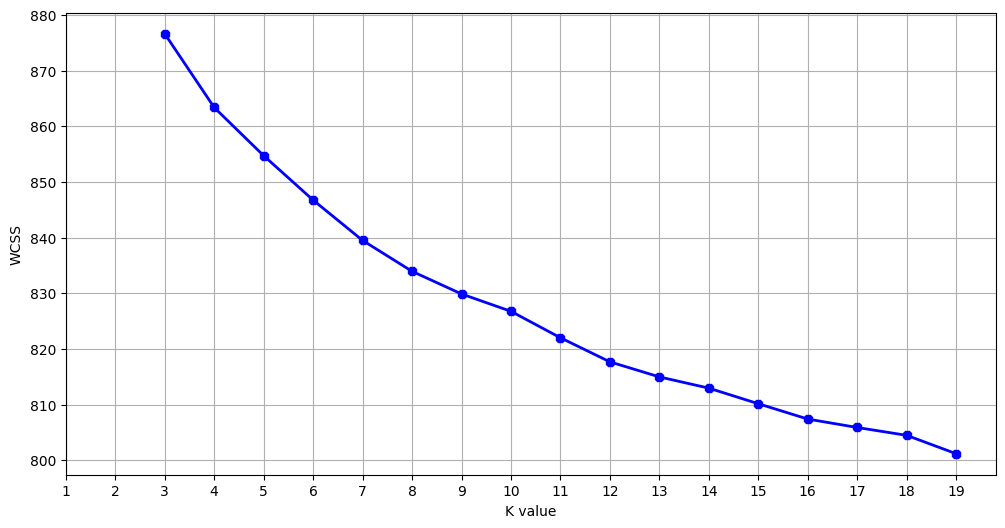

In [ ]:
# find number cluster use tf-idf
wcss = []
for k in range(3, 20):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(3,20),wcss, linewidth=2, color="blue",marker="8")
plt.xlabel("K value")
plt.xticks(np.arange(1,20,1))
plt.ylabel("WCSS")
plt.show()

In [ ]:
# cluster with 7 clusters that are found above
num_clusters = 8

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [ ]:
km.cluster_centers_.argsort()[:, ::-1]

array([[ 373,    9,  504, ...,  540,  907,  681],
       [  34,  904, 1118, ...,  226,  390,  307],
       [ 863,  504,  262, ...,  489,  244,    7],
       ...,
       [ 504,  863,  262, ...,  679,   67,  183],
       [ 495,   34,  904, ...,  375,  528,  846],
       [ 129,  863,  360, ..., 1034,  146,  374]], dtype=int64)

In [ ]:
# show top word per cluster, which show interest of each cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 iphone
 apple
 mua
 máy
 samsung
 xài
 tiền
 android
 giá
 màn_hình
Cluster 1:
 bóng
 trận
 đội
 cầu_thủ
 việt_nam
 thắng
 hlv
 thua
 giải
 tiền
Cluster 2:
 tiền
 mua
 giá
 học
 lương
 đất
 đầu
 lao_động
 thuế
 đóng
Cluster 3:
 tui
 mua
 mấy
 tiền
 chạy
 học
 giá
 đường
 chả
 lắm
Cluster 4:
 thi
 gia
 việt_nam
 pha
 chi
 mua
 tha
 chúc_mừng
 tiền
 chúc
Cluster 5:
 mua
 tiền
 giá
 đường
 chạy
 máy
 nga
 mấy
 điện
 lái
Cluster 6:
 messi
 bóng
 trận
 fan
 cr7
 barca
 đội
 cầu_thủ
 real
 ghi_bàn
Cluster 7:
 chồng
 tiền
 học
 sống
 gia_đình
 mua
 thể
 gái
 mấy
 đừng


C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Save model parameters
pickle.dump(km, open("%smodel_kmeans.pickle.dat"%location, "wb"))

In [ ]:
# reduce the dimension tf-idf
dist = 1 - cosine_similarity(tfidf_matrix)
dist

MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
# set name to cluster
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4', 
                 5: 'Cluster 5',
                 6: 'Cluster 6',
                 7: 'Cluster 7',
                 }

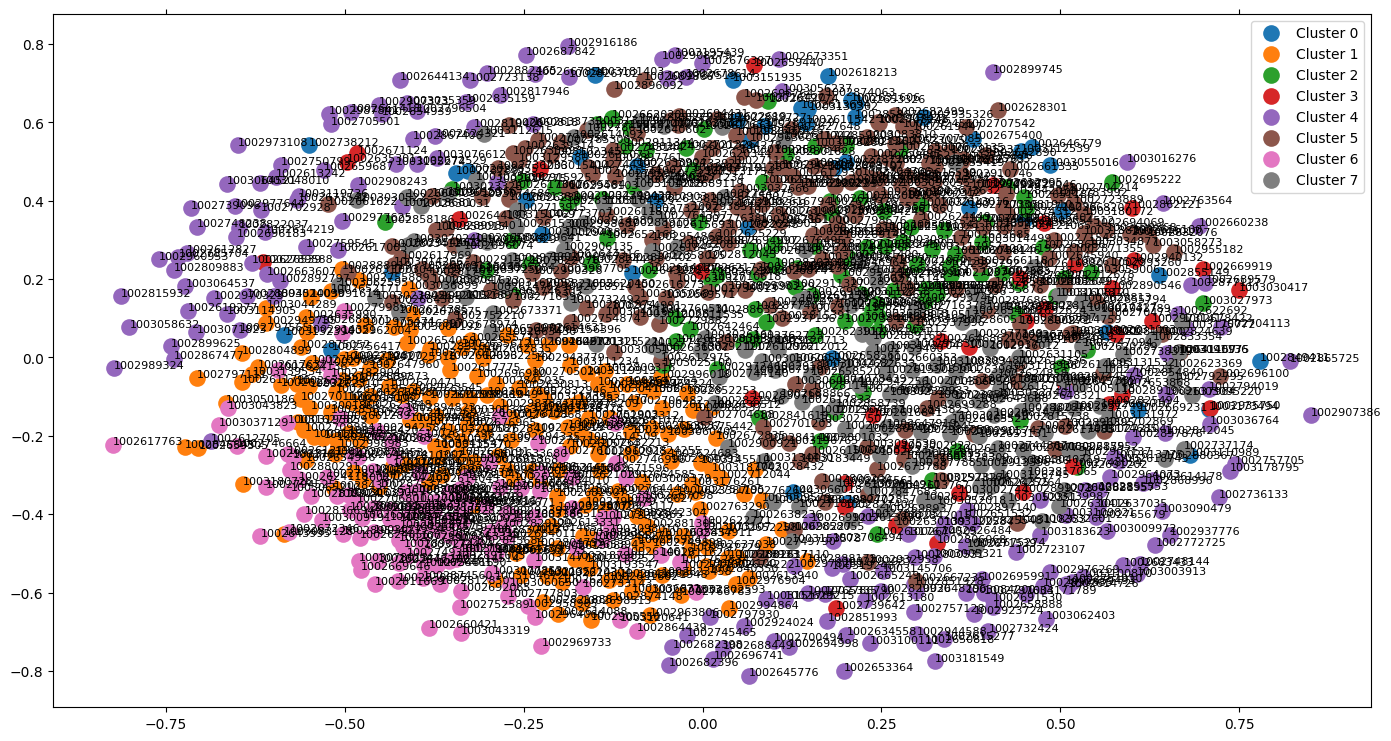

In [ ]:
# plot clusters
%matplotlib inline 

titles = data.userid

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

plt.show()

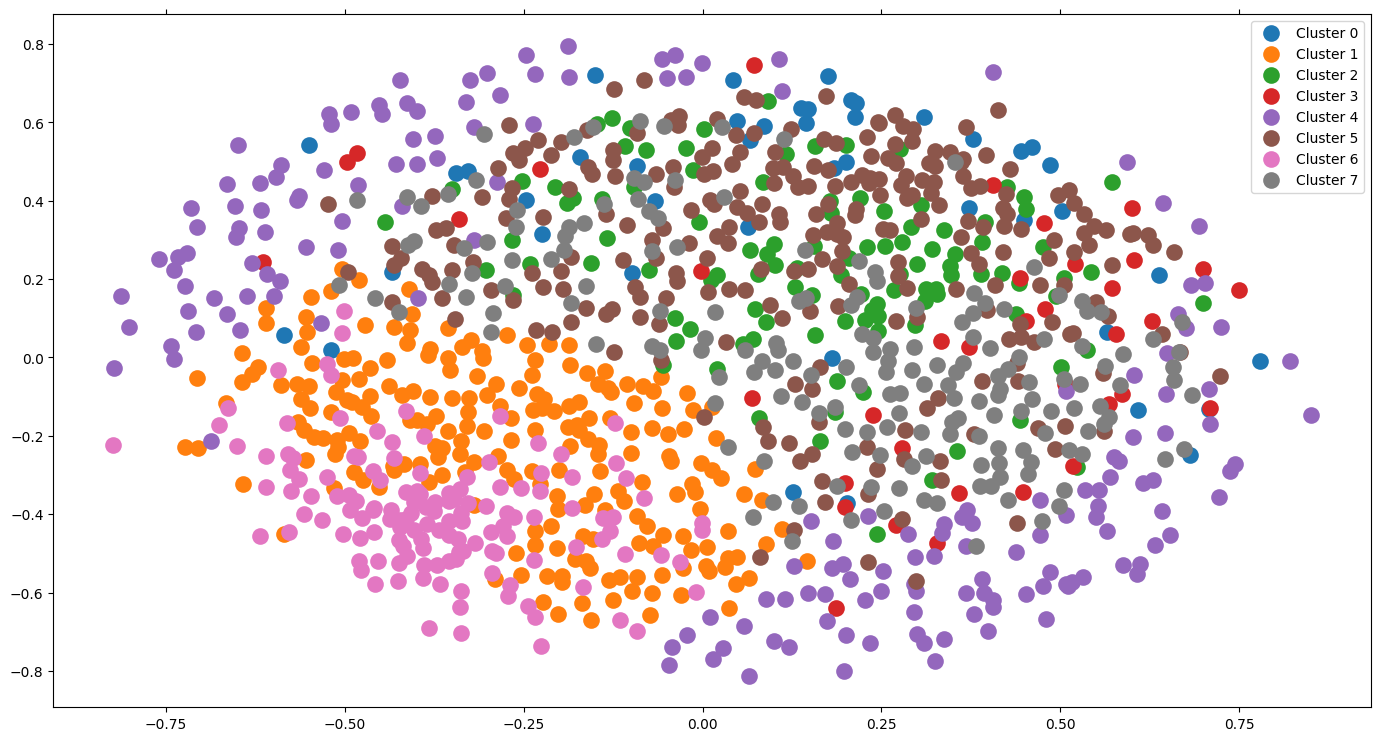

In [ ]:
# plot cluster without userid
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)    
plt.show()

In [ ]:
#adding cluster labels in the usersData. (add one column into dataframe) 
data['cluster'] = clusters

In [ ]:
data.head()

,userid,comments,comments_id,article_id,title,url,pcomment,cluster
0,1002611535,"[Ủa, iOS có tính năng khóa App từ lâu rồi mà. ...","[47968853, 47800135, 47703811, 47645657, 47584...","[4529373, 4527283, 4524455, 4522989, 4521000, ...",[Ý tưởng iOS 17 có khóa ứng dụng - VnExpress S...,[https://vnexpress.net/y-tuong-ios-17-co-khoa-...,ios tính_năng khoá app mục screen time nguyên_...,2
1,1002611542,[Lâu nay phạt nguội xe máy vẫn là vấn đề nan g...,"[48165879, 48157811, 48157769, 48132386, 48088...","[4537874, 4537422, 4537406, 4535990, 4535329, ...","[Môtô CSGT tông liên hoàn, ba người bị thương ...",[https://vnexpress.net/moto-csgt-tong-lien-hoa...,phạt nguội máy vấn nan_giải phương xác_định ch...,0
2,1002611620,[Messi 0d nhưng lại được định giá gần gấp 3 lầ...,"[48163846, 48163447, 48162509, 48159323, 48156...","[4537829, 4537929, 4537576, 4537847, 4537527, ...",[10 đội tuyển đắt giá nhất tại World Cup 2022 ...,[https://vnexpress.net/10-doi-tuyen-dat-gia-nh...,messi định_giá gấp thiên phản_bội ghi haha lik...,6
3,1002611661,[Hy vọng 30 năm nữa hoàn thành để tôi có thể đ...,"[47983237, 38548809, 37953883, 37023659, 36523...","[4528558, 4226031, 4201350, 4167048, 4144167, ...",[Nghiên cứu đường sắt tốc độ cao 250 km/h - Vn...,[https://vnexpress.net/nghien-cuu-duong-sat-to...,vọng hoàn_thành thể chuyến chết tội mấy tung_t...,2
4,1002611711,[Năm rồi vì 20 giây<br/>Mà cả đội bóng vạ lây ...,"[46444497, 46311714, 43222717, 42102514, 42097...","[4492456, 4488831, 4396253, 4356490, 4356752, ...",[Man Utd có thể nhờ Ferguson thuyết phục Ronal...,[https://vnexpress.net/man-utd-co-the-nho-ferg...,giây đội bóng lây chàng đôn_đáo chạy_làng rải ...,6


# 4. Perform Topic Modelling

In [ ]:
# get doc from pcomments
docs = array(data['pcomment'].apply(lambda x: x.split()))

In [ ]:
# Built dictionary and corpus from docs
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 6868
Number of documents: 1172
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 5), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 1), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 1), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1), (38, 2), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 3), (46, 2), (47, 1), (48, 2), (49, 4), (50, 1), (51, 1), (52, 1), (53, 4), (54, 1), (55, 3), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 7), (72, 1), (73, 1), (74, 1), (75, 6), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 8), (89, 1), (90, 4), (91, 1), (92, 1), (93, 1), (94, 4), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (1

In [ ]:
# add 2 column into dataframe
data['corpus'] = corpus
data['docs'] = docs
# create unique list of names
UniqueNames = data['cluster'].unique()

In [ ]:
#create a data frame dictionary to store data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
docscluster={elem : pd.DataFrame for elem in UniqueNames}
corpuscluster={elem : pd.DataFrame for elem in UniqueNames}
dictionarycluster={elem : pd.DataFrame for elem in UniqueNames}

In [ ]:
# slip data by cluster
for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data.cluster == key]
    docscluster[key]=data['docs'][data.cluster == key]
    corpuscluster[key]=data['corpus'][data.cluster == key]
    dictionarycluster[key]=Dictionary(docscluster[key])

In [ ]:
# create LDA modeling
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# save model
lda_model.save("/model_lda_100.model")

# Save model parameters
pickle.dump(lda_model, open("%smodel_lda_100.model"%location, "wb"))

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.873353286114313

Coherence Score:  0.5625135625256482


## 3.1 Perform topic modelling for each cluster

In [ ]:
# Function to loop computing coherence measures for tuning LDAMallet model
#Used c_v parameter as method for computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:ocs
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        try:
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        except:
            corpus = [dictionary.doc2bow(doc) for doc in docs]
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# topic modeling and calculate coherence_values
model_list={elem : pd.DataFrame for elem in UniqueNames }
coherence_values={ elem : pd.DataFrame for elem in UniqueNames}
for i in np.arange(num_clusters):
    model_list[i], coherence_values[i] = compute_coherence_values(dictionary=dictionarycluster[i]
    , corpus=corpuscluster[i], texts=docscluster[i], start=2, limit=7, step=1)

In [ ]:
# Print the coherence scores
# Find number of topic for each cluster

best_value=np.array([])
optimal_model={elem : pd.DataFrame for elem in UniqueNames }
for i in np.arange(num_clusters):
    coherence_values[i]=[value for value in coherence_values[i] if not math.isnan(value)]
    best_value=np.append(best_value, np.amax(coherence_values[i])) 
    t=int(np.argmax(coherence_values[i]))
    optimal_model[i]=model_list[i][t]
    print("Cluster=",i,"has optimal number of topics as", t+2)#######################################################

Cluster= 0 has optimal number of topics as 4
Cluster= 1 has optimal number of topics as 6
Cluster= 2 has optimal number of topics as 5
Cluster= 3 has optimal number of topics as 3
Cluster= 4 has optimal number of topics as 6
Cluster= 5 has optimal number of topics as 4
Cluster= 6 has optimal number of topics as 4
Cluster= 7 has optimal number of topics as 5


In [ ]:
coherence_values

{2: [0.6296919109652989,
  0.6592743965168018,
  0.6719364030699453,
  0.6739837388637641,
  0.6524823070430753],
 0: [0.6581445295827133,
  0.6485029486737558,
  0.6749602469173925,
  0.6481521473936216,
  0.6474791204384522],
 6: [0.6690071675771702,
  0.6876560771768855,
  0.6879936797764097,
  0.6625517788677179,
  0.6441589046468591],
 7: [0.6321952427980595,
  0.6093598250791815,
  0.6236911719702858,
  0.6678190911605739,
  0.6308407782595665],
 1: [0.5462305563314289,
  0.5848263641523727,
  0.6053272061190825,
  0.6063925268505378,
  0.6176705918978457],
 5: [0.6079310147939008,
  0.6272442372741694,
  0.6662345748485178,
  0.6383087007097938,
  0.6327866701371613],
 3: [0.29936964525200976,
  0.42092575244378766,
  0.37404702754835506,
  0.3679426542919431,
  0.3410788674722907],
 4: [0.6211794183807333,
  0.6480489877382027,
  0.6686671892359662,
  0.6536727430943419,
  0.6866910092878099]}

In [ ]:
optimal_model[3].print_topics(num_words=100)

[(0,
  '0.029*"là" + 0.028*"có" + 0.023*"thì" + 0.019*"người" + 0.017*"và" + 0.014*"của" + 0.014*"cũng" + 0.014*"mà" + 0.013*"bạn" + 0.012*"được" + 0.012*"này" + 0.012*"làm" + 0.011*"phải" + 0.010*"các" + 0.010*"còn" + 0.009*"rồi" + 0.009*"lại" + 0.009*"để" + 0.008*"chỉ" + 0.008*"nhiều" + 0.008*"với" + 0.008*"sẽ" + 0.008*"mình" + 0.008*"gì" + 0.007*"đó" + 0.007*"rất" + 0.007*"nào" + 0.006*"nói" + 0.006*"những" + 0.006*"nhà" + 0.006*"mới" + 0.006*"cái" + 0.006*"công" + 0.006*"quá" + 0.006*"một" + 0.006*"thế" + 0.006*"thể" + 0.006*"biết" + 0.006*"cả" + 0.006*"vậy" + 0.005*"về" + 0.005*"đến" + 0.005*"họ" + 0.005*"vào" + 0.005*"thành" + 0.005*"nếu" + 0.005*"thấy" + 0.005*"đã" + 0.005*"đúng" + 0.005*"học" + 0.005*"tiền" + 0.005*"bóng" + 0.005*"nó" + 0.005*"khác" + 0.005*"nước" + 0.005*"giờ" + 0.004*"cần" + 0.004*"chứ" + 0.004*"đá" + 0.004*"thời" + 0.004*"nhất" + 0.004*"việc" + 0.004*"thủ" + 0.004*"giá" + 0.004*"chính" + 0.004*"

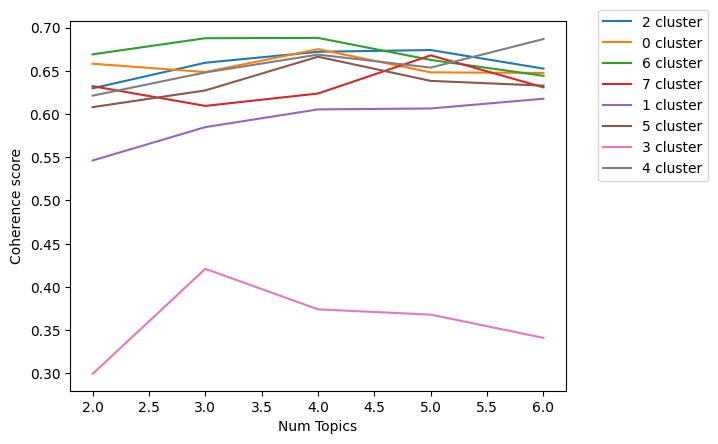

In [ ]:
# plot coherence socre of each cluster
limit=7; start=2; step=1;
x={elem:list(range(start, limit, step)) for elem in (UniqueNames)}
for key in x.keys():
    plt.plot(x[key],coherence_values[key], label= str(key)+ ' cluster') 
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    
plt.legend(loc='best',bbox_to_anchor=(1.05, 1.05))
#plt.show()
plt.savefig('Coherence Sscor.png',bbox_inches='tight')

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_model = optimal_model[2]
vis2 = pyLDAvis.gensim.prepare(lda_model, corpuscluster[2], dictionarycluster[2])
vis2

c:\Program Files\Python39\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.022800 -0.176068       1        1  48.671343
3      0.228140  0.063666       2        1  32.016442
1     -0.026231  0.019901       3        1  12.269638
4     -0.107663  0.089358       4        1   6.563285
2     -0.117045  0.003143       5        1   0.479293, topic_info=            Term       Freq      Total Category  logprob  loglift
3833   cồng_kềnh  90.000000  90.000000  Default  30.0000  30.0000
6293       qhoàn  47.000000  47.000000  Default  29.0000  29.0000
23       anh_chị  72.000000  72.000000  Default  28.0000  28.0000
3689  nhiệt_điện  51.000000  51.000000  Default  27.0000  27.0000
3406        khám  30.000000  30.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
183         diaz   0.078198   3.056420   Topic5  -7.9937   1.6749
769     tuổi_thơ   0.088264  15.008536   Topic5  -7.8726   0.2046
1577   thăm_thẳm   0.080101   6.099225   Topic5  -7.9697   1.0080
3062        tài   0.079246   7.543770   Topic5  -7.9804   0.7847
3610   cung_cách   0.079596  15.129353   Topic5  -7.9760   0.0932

[338 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1730      1  0.723259       1500
1730      3  0.180815       1500
1730      4  0.090407       1500
1165      2  0.951852     2000đl
1175      1  0.354427       2020
...     ...       ...        ...
3303      2  0.952212  đội_tuyển
1147      1  0.059815   động_lực
1147      2  0.059815   động_lực
1147      3  0.837413   động_lực
5420      1  0.571721        ươm

[549 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3])

In [ ]:
# def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)


# 5. Calculate sentiment score for each cluster lean on comments

In [ ]:
# read lexicon dictionary
list_word = pd.read_excel(r'D:\ITfiles\PythonFiles\News-Recommendation-System\VnEmoLex.xlsx')
list_word = list_word.drop(['Unnamed: 0'], axis=1)
list_word.Vietnamese = list_word.Vietnamese.str.lower()
list_word.Vietnamese = list_word.Vietnamese.str.strip()
list_word.Vietnamese = list_word.Vietnamese.str.replace(' ', '_')
list_word.columns = ['Vietnamese', 'Positive','Negative',
'Anger', 'Anticipation','Disgust',
'Fear','Joy','Sadness','Surprise',
'Trust','Total']

pos_word = list_word.loc[(list_word.Positive == 1) | (list_word.Anticipation == 1) 
| (list_word.Joy == 1) | (list_word.Surprise == 1) | (list_word.Trust == 1),'Vietnamese'].to_list()
neg_word = list_word.loc[(list_word.Negative == 1) | (list_word.Anger == 1) |
(list_word.Disgust == 1) | (list_word.Fear == 1) | (list_word.Sadness == 1) ,'Vietnamese'].to_list()

# build function to calculate_sentiment_score
def calculate_sentiment_score(i):
    num_pos = DataFrameDict[i].docs.map(lambda x: len([i for i in x if i in pos_word]))
    num_neg = DataFrameDict[i].docs.map(lambda x: len([i for i in x if i in neg_word]))
    total_len = DataFrameDict[i].docs.map(lambda x: len(x))

    return round((num_pos.sum() - num_neg.sum())/ total_len.sum(),6)
    

In [ ]:
sentimentscorecluster = {elem : pd.DataFrame for elem in UniqueNames}

for i in DataFrameDict.keys():
    sentimentscorecluster[i] = calculate_sentiment_score (i)
    print('{}, score: {}'.format(i,sentimentscorecluster[i]))

2, score: 0.072294
0, score: 0.043645
6, score: 0.048361
7, score: 0.073401
1, score: 0.053209
5, score: 0.05307
3, score: 0.050132
4, score: 0.039421


# 6. Analyze News articles

In [ ]:
# Load dataset
df_articles = pd.read_csv(r'D:\ITfiles\PythonFiles\News-Recommendation-System\Datatest\TongHop.csv')

In [ ]:
df_articles.shape

(548, 3)

In [ ]:
# function to preprocess articles
def processArticles(contents):
    #cleaning of contents
    cleanedcontents = []
    for content in contents:
        clean = re.compile('<.*?>')
        content = re.sub(clean, ' ', content) # remove html tags

        cm = re.sub('http\S+', '', content) #remove links
        
        cm = "".join([char for char in cm if char not in string.punctuation]) #remove punctuations
        
        cm = cm.lower() #converting to lowercase letters
        
        cm = ' '.join([word for word in cm.split() if word not in (stop)]) #removing stop words (có vấn đề)
        
        cm = ' '.join([word for word in cm.split() if len(word)>2])
        
        cm = segmenter.word_segment(cm)[0] #tokenize
        cm = ' '.join([word for word in cm.split() if word not in (stop)]) #removing stop words
        cleanedcontents.append(cm)
        
    return cleanedcontents


df_articles['news_content'] = processArticles(df_articles['news_content'])

<>:9: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \S
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\3033568420.py:9: DeprecationWarning: invalid escape sequence \S
  cm = re.sub('http\S+', '', content) #remove links


## 5.1 Topic modeling

In [ ]:
# tạo docs, dictionary
from numpy import array

docs = array(df_articles['news_content'].apply(lambda x : x.split()))
df_articles['docs'] = df_articles['news_content'].apply(lambda x : x.split())

In [ ]:
# Remove rare and common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1400
Number of documents: 548


In [ ]:
# Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
# The percent contribution of each topic model considered as metric to assign topic score
df_topic_sents_keywords={elem : pd.DataFrame for elem in UniqueNames}
topicss=pd.DataFrame()
for i in range(len(UniqueNames)):
    mod=optimal_model[i]
    temp={'cluster':i,
         'model':mod}
    topicss=topicss.append(temp, ignore_index=True)
    df_topic_sents_keywords[i] = format_topics_sentences(ldamodel=mod, corpus=corpus, texts=docs)
    # Centre the percent contribution by subtracting the mean. This standardises topic score (chuẩn hóa)
    df_topic_sents_keywords[i]['Diff']= df_topic_sents_keywords[i]['Perc_Contribution']-np.mean(df_topic_sents_keywords[i]['Perc_Contribution'])

C:\Users\marti\AppData\Local\Temp\ipykernel_6548\3113384864.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topicss=topicss.append(temp, ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\1391231544.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\3113384864.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topicss=topicss.append(temp, ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\1391231544.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

In [ ]:
df_topic_sents_keywords[0]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0,Diff
0,0,0.3701,"thỏ, hơi, khịa, lãi, làn, bản_quyền, facebook,...","[mỹmái, tóc, bồng_bềnh, khuôn_mặt, xinh_đẹp, v...",-0.17103
1,2,0.5490,"thỏ, thể_hiện, tết, facebook, làn, loáng_thoán...","[vọng, món, lươn, nướng, chiến_thắng, croatia,...",0.00787
2,3,0.6522,"thỏ, thể_hiện, tết, hơi, làn, bão, facebook, r...","[tần_suất, gội, đầu, tuỳ, yếu, bao, kiểu, tóc,...",0.11107
3,0,0.3526,"thỏ, hơi, khịa, lãi, làn, bản_quyền, facebook,...","[hầu, già, hạn_chế, công_nghệ, khăn, dụng, thi...",-0.18853
4,2,0.4034,"thỏ, thể_hiện, tết, facebook, làn, loáng_thoán...","[nổi_tiếng, khao_khát, huỷ_hoại, hạnh_phúc, th...",-0.13773
...,...,...,...,...,...
543,2,0.3976,"thỏ, thể_hiện, tết, facebook, làn, loáng_thoán...","[huyện, ngoại_thành, nghị, chủ_trương, thành_p...",-0.14353
544,2,0.5510,"thỏ, thể_hiện, tết, facebook, làn, loáng_thoán...","[địa_phương, chậm, giải_phóng, mặt, tốc, bắc_n...",0.00987
545,2,0.3799,"thỏ, thể_hiện, tết, facebook, làn, loáng_thoán...","[quyền, thành_phố, sung, hai, địa_danh_son, th...",-0.16123
546,2,0.4617,"thỏ, thể_hiện, tết, facebook, làn, loáng_thoán...","[lịch, nghỉ, tết, 2023, 2023, công_chức, lao_đ...",-0.07943


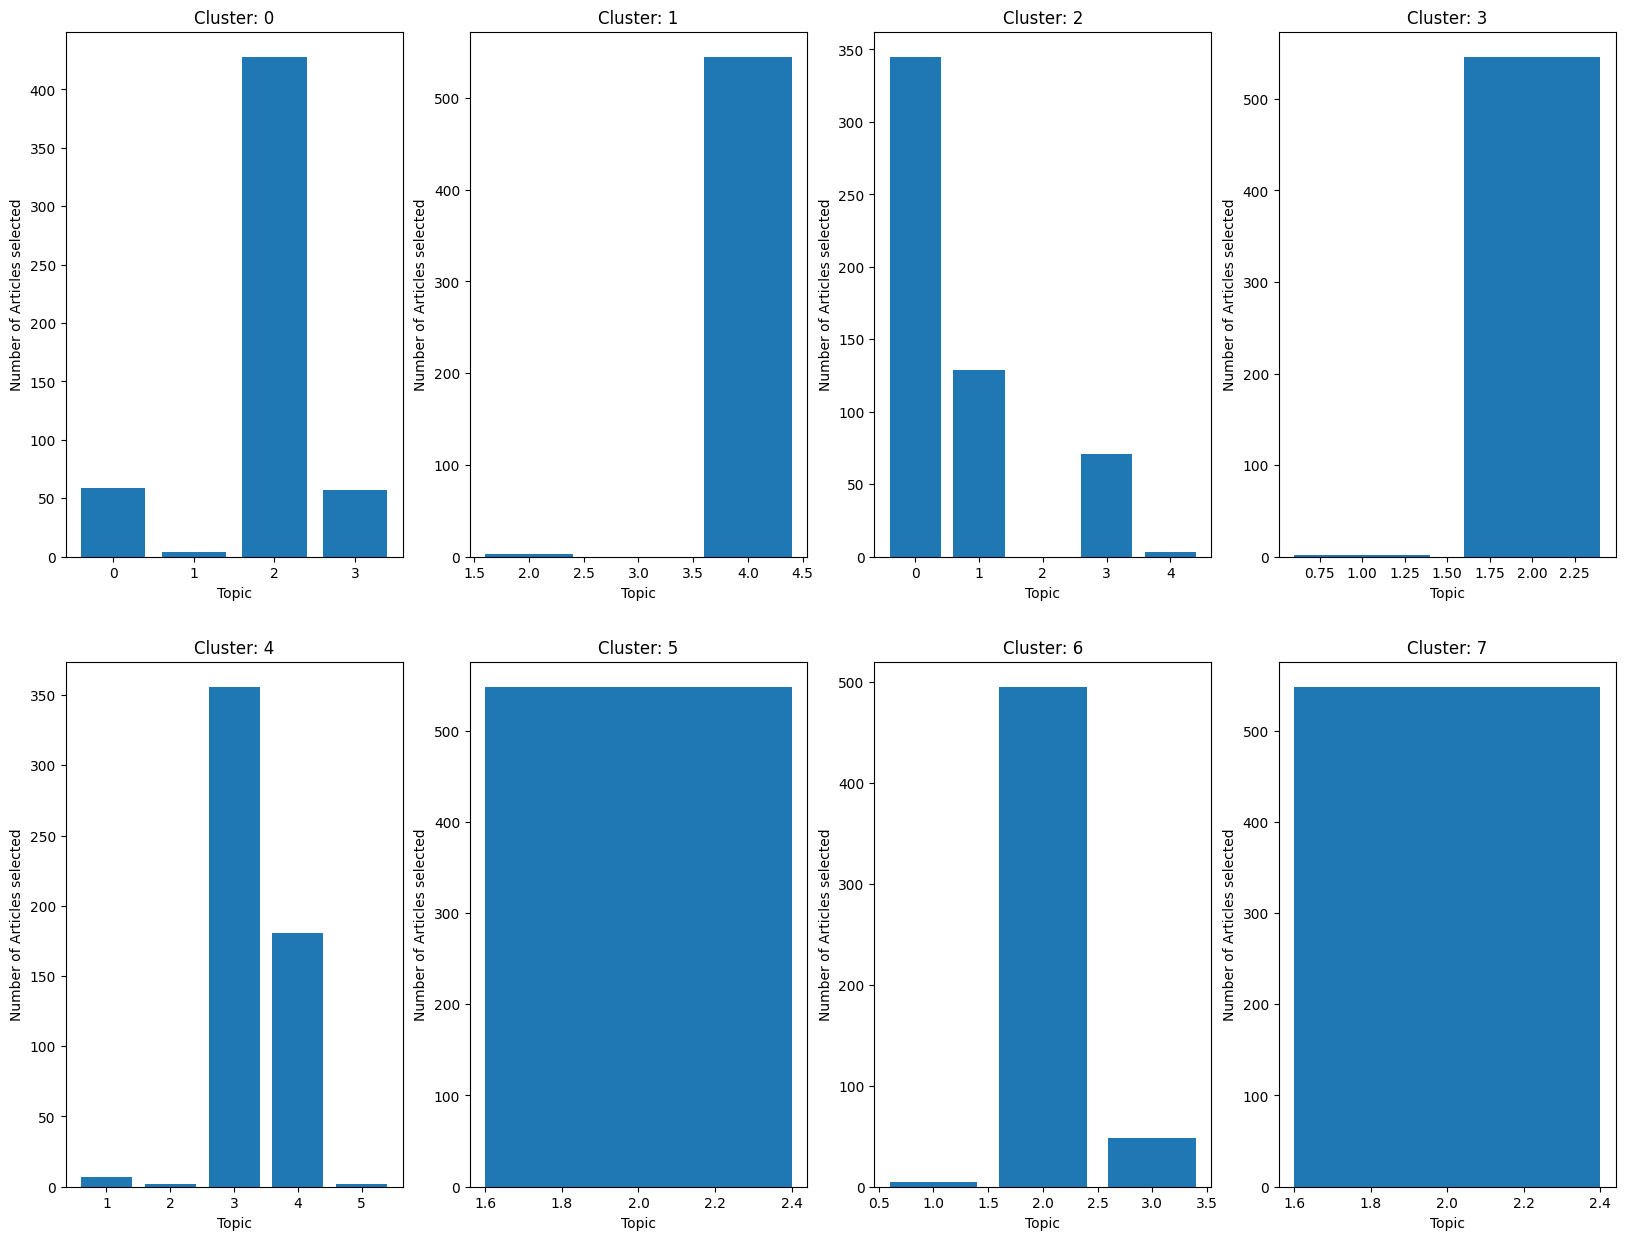

In [ ]:
count = 0
fig, axs = plt.subplots(2,4)

for i in range(0,2):
    for j in range(0,4):
        if (count <=7):
            axs[i,j].bar(df_topic_sents_keywords[count]['Dominant_Topic'].value_counts().index,df_topic_sents_keywords[count]['Dominant_Topic'].value_counts())
            str_ = "Cluster: " + str(count)
            axs[i,j].set_title(str_)
            count +=1
fig.set_figheight(15)
fig.set_figwidth(20)
for ax in axs.flat:
    ax.set(xlabel='Topic', ylabel='Number of Articles selected')

plt.savefig('Percentage Topic.png',bbox_inches='tight')

## 5.2 Calculate sentiment scores for each article

In [ ]:
list_word = pd.read_excel(r'D:\ITfiles\PythonFiles\News-Recommendation-System\VnEmoLex.xlsx')
list_word = list_word.drop(['Unnamed: 0'], axis=1)
list_word.Vietnamese = list_word.Vietnamese.str.lower()
list_word.Vietnamese = list_word.Vietnamese.str.strip()
list_word.Vietnamese = list_word.Vietnamese.str.replace(' ', '_')
list_word.columns = ['Vietnamese', 'Positive','Negative',
'Anger', 'Anticipation','Disgust',
'Fear','Joy','Sadness','Surprise',
'Trust','Total']

pos_word = list_word.loc[(list_word.Positive == 1) | (list_word.Anticipation == 1) 
| (list_word.Joy == 1) | (list_word.Surprise == 1) | (list_word.Trust == 1),'Vietnamese'].to_list()
neg_word = list_word.loc[(list_word.Negative == 1) | (list_word.Anger == 1) |
(list_word.Disgust == 1) | (list_word.Fear == 1) | (list_word.Sadness == 1) ,'Vietnamese'].to_list()

num_pos = df_articles.docs.map(lambda x: len([i for i in x if i in pos_word]))
num_neg = df_articles.docs.map(lambda x: len([i for i in x if i in neg_word]))
total_len = df_articles.docs.map(lambda x: len(x))

df_articles['sentiment_score'] = round((num_pos- num_neg)/ total_len,6)

## 5.3 Calculate metric score recommendation

In [ ]:
sentiment={elem: pd.DataFrame for elem in UniqueNames}
#subjectivit={elem: pd.DataFrame for elem in UniqueNames}
w1=0.8 # Topic modelling weight
w2=0.2 # Sentiment score weight
for i in range(len(UniqueNames)):
    sentiment[i]=cosine_similarity(np.array(df_articles.iloc[:, -1]).reshape(-1, 1),np.array([sentimentscorecluster[i]]).reshape(-1, 1))
    #subjectivit[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([subjectivitycluster[i]]).reshape(-1, 1))
    df_topic_sents_keywords[i]['Sentiment']=sentiment[i]
    #df_topic_sents_keywords[i]['Subjectivity']=subjectivit[i]
    df_topic_sents_keywords[i]['Metric']=w1*df_topic_sents_keywords[i]['Diff'] + w2*df_topic_sents_keywords[i]['Sentiment']

In [ ]:
recommend=pd.DataFrame()
metric_value=pd.DataFrame()
rec=np.array([])
for i in range(len(docs)):
    for j in range(len(UniqueNames)):
        rec=np.append(rec, df_topic_sents_keywords[j].iloc[i,-1])

    recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
    metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)
    rec=np.array([])


C:\Users\marti\AppData\Local\Temp\ipykernel_6548\1334659417.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\1334659417.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)


In [ ]:
recommend['metric']=metric_value
recommend['url']=df_articles['URL']
recommend['article_text']=df_articles['news_content']
recommend.rename(columns={0:'cluster'},inplace=True)

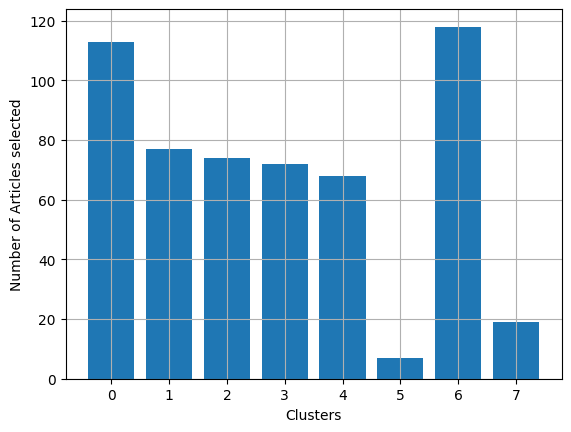

In [ ]:
plt.bar(recommend['cluster'].value_counts().index,recommend['cluster'].value_counts())
plt.grid()
plt.xlabel('Clusters')
plt.ylabel('Number of Articles selected')
plt.savefig('Percentage Recommend.png',bbox_inches='tight')

In [ ]:
recommend.to_csv('%srecommend.csv'%location,index=None)

In [ ]:
pd.set_option('display.max_rows', None)

# 7. Recommendation system

In [ ]:
# read data 
test_data = pd.read_csv(r'D:\ITfiles\PythonFiles\News-Recommendation-System\Use-vnexpress-data\data.csv')

test_data =  test_data.iloc[20000:25000,:]

In [ ]:
# get user data to recommend
userid_list = list(test_data['userid'].unique())
data_rec = pd.DataFrame(columns = ["userid","comments","comments_id","article_id","title",'url'])

for i in userid_list:
    try:
        temp = int(i)
        data_rec = combineComments(i,data_rec)
    except:
        print('x')
        continue

x


C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(append, index = ["userid","comments","comments_id","article_id","title",'url']),
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\2350712596.py:1

In [ ]:
# tiền xử lý
data_rec["pcomment"] = data_rec['comments'].apply(lambda x : processComments(x))

## 6.1 Function to calculate final score for recommendations

In [ ]:
def get_jaccard_sim(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
def GetUserRec(recommend, pcomments,cluster):

    articles=recommend[recommend['cluster']==cluster]
    articles.dropna(inplace=True)
    articles['corp']= processArticles(articles['article_text'])

    articles['jaccard']=articles['article_text'].apply(lambda x:get_jaccard_sim(pcomments,x))
    articles['final_score']=0.5*articles['jaccard']+0.5*articles['metric']
    ranked=articles.sort_values(by=['final_score'], ascending=False)
    
    #print('comments list: ',pcomments)
    #print('cluster: ', cluster)
    #print('articles: ', articles)

    return ranked

## 6.2 Pipeline to recommend

In [ ]:
# 6.2.1 read model
tfidf_vectorizer = pickle.load(open('model/model_tfidf.pickle.dat','rb'))
km = pickle.load(open('model/model_kmeans.pickle.dat','rb'))


In [ ]:
# 6.2.1 cluster 
tfidf_matrix = tfidf_vectorizer.transform(data_rec.pcomment)
cluster = km.predict(tfidf_matrix)
cluster

array([2, 2, 6, 0, 4, 2, 2, 4, 2, 2, 1, 2, 6, 2, 1, 4, 3, 2, 1, 1, 1, 1,
       4, 3, 2, 3, 2, 2, 2, 1, 2, 4, 1, 1, 3, 2, 4, 5, 1, 2, 1, 7, 4, 2,
       7, 4, 5, 4, 2, 3, 2, 2, 0, 2, 7, 2])

In [ ]:
# 6.2.3 read articles recommend dataframe
recommend = pd.read_csv('model/recommend.csv')
recommend.sort_values(by='metric',ascending=False,inplace=True,)

In [ ]:
# 6.2.4 recommend
GetUserRec(recommend,data_rec["pcomment"].values[16],cluster[16])[['url','final_score']].head(10)

GetUserRec(recommend,data_rec["pcomment"].values[16],cluster[16])[['url','final_score']].head(10)

C:\Users\marti\AppData\Local\Temp\ipykernel_6548\359999556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles.dropna(inplace=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\359999556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['corp']= processArticles(articles['article_text'])
C:\Users\marti\AppData\Local\Temp\ipykernel_6548\359999556.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https